# UIDAI Hackathon PS-1: Data Cleaning
## Predictive Analysis of Aadhaar Update Demand

This notebook performs comprehensive data cleaning on three Aadhaar datasets:
1. **Enrolment Data**: New Aadhaar enrollments by age group
2. **Demographic Data**: Demographic update requests
3. **Biometric Data**: Biometric update requests

### Cleaning Tasks:
- Date format conversion and standardization
- Missing value handling
- Duplicate removal
- Outlier detection and handling
- Text standardization
- Data validation
- Cross-dataset consistency checks

### Outputs:
- Cleaned datasets saved to `outputs/results/`
- Before/after comparison statistics
- Visualizations of data quality improvements

## 1. Import Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.4.1
Matplotlib version: 3.10.8
Seaborn version: 0.13.2


## 2. Define Paths and Load Data

In [4]:
# Define paths
BASE_PATH = Path('/home/prince/Desktop/UIDAI Hackathon')
DATASET_PATH = BASE_PATH / 'dataset'

ENROLMENT_PATH = DATASET_PATH / 'api_data_aadhar_enrolment'
DEMOGRAPHIC_PATH = DATASET_PATH / 'api_data_aadhar_demographic'
BIOMETRIC_PATH = DATASET_PATH / 'api_data_aadhar_biometric'

OUTPUT_PATH = BASE_PATH / 'outputs' / 'results'
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

print("Paths configured:")
print(f"Enrolment: {ENROLMENT_PATH}")
print(f"Demographic: {DEMOGRAPHIC_PATH}")
print(f"Biometric: {BIOMETRIC_PATH}")
print(f"Output: {OUTPUT_PATH}")

Paths configured:
Enrolment: /home/prince/Desktop/UIDAI Hackathon/dataset/api_data_aadhar_enrolment
Demographic: /home/prince/Desktop/UIDAI Hackathon/dataset/api_data_aadhar_demographic
Biometric: /home/prince/Desktop/UIDAI Hackathon/dataset/api_data_aadhar_biometric
Output: /home/prince/Desktop/UIDAI Hackathon/outputs/results


In [5]:
def load_and_concatenate_csvs(folder_path, dataset_name):
    """Load all CSV files from a folder and concatenate them"""
    csv_files = sorted(glob.glob(str(folder_path / '*.csv')))
    
    if not csv_files:
        print(f"No CSV files found in {folder_path}")
        return None
    
    print(f"\n{dataset_name} - Loading {len(csv_files)} files...")
    dfs = []
    for file in csv_files:
        df = pd.read_csv(file)
        dfs.append(df)
    
    combined_df = pd.concat(dfs, ignore_index=True)
    print(f"Loaded {combined_df.shape[0]:,} rows × {combined_df.shape[1]} columns")
    
    return combined_df

# Load all datasets
print("=" * 80)
print("LOADING DATASETS")
print("=" * 80)

df_enrolment = load_and_concatenate_csvs(ENROLMENT_PATH, "Enrolment")
df_demographic = load_and_concatenate_csvs(DEMOGRAPHIC_PATH, "Demographic")
df_biometric = load_and_concatenate_csvs(BIOMETRIC_PATH, "Biometric")

print("\n✓ All datasets loaded successfully!")

LOADING DATASETS

Enrolment - Loading 3 files...
Loaded 1,006,029 rows × 7 columns

Demographic - Loading 5 files...
Loaded 2,071,700 rows × 6 columns

Biometric - Loading 4 files...
Loaded 1,861,108 rows × 6 columns

✓ All datasets loaded successfully!


In [6]:
def record_statistics(df, dataset_name):
    """Record dataset statistics before/after cleaning"""
    stats = {
        'Dataset': dataset_name,
        'Total_Rows': len(df),
        'Total_Columns': len(df.columns),
        'Missing_Values': df.isnull().sum().sum(),
        'Missing_Percentage': (df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100,
        'Duplicate_Rows': df.duplicated().sum(),
        'Duplicate_Percentage': (df.duplicated().sum() / len(df)) * 100,
    }
    
    # Count negative values in numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    negative_count = sum((df[col] < 0).sum() for col in numeric_cols)
    stats['Negative_Values'] = negative_count
    
    return stats

# Record initial statistics
print("=" * 80)
print("INITIAL DATA QUALITY STATISTICS (BEFORE CLEANING)")
print("=" * 80)

initial_stats = []
initial_stats.append(record_statistics(df_enrolment, 'Enrolment'))
initial_stats.append(record_statistics(df_demographic, 'Demographic'))
initial_stats.append(record_statistics(df_biometric, 'Biometric'))

initial_stats_df = pd.DataFrame(initial_stats)
display(initial_stats_df)

# Create copies for cleaning
df_enrolment_clean = df_enrolment.copy()
df_demographic_clean = df_demographic.copy()
df_biometric_clean = df_biometric.copy()

print("\n✓ Initial statistics recorded and working copies created")

INITIAL DATA QUALITY STATISTICS (BEFORE CLEANING)


,Dataset,Total_Rows,Total_Columns,Missing_Values,Missing_Percentage,Duplicate_Rows,Duplicate_Percentage,Negative_Values
0,Enrolment,1006029,7,0,0.00,22957,2.28,0
1,Demographic,2071700,6,0,0.00,473601,22.86,0
2,Biometric,1861108,6,0,0.00,94896,5.10,0



✓ Initial statistics recorded and working copies created


## 3. Record Initial Statistics (Before Cleaning)

In [7]:
def plot_missing_values(df, title):
    """Create heatmap of missing values"""
    plt.figure(figsize=(12, 6))
    
    # Calculate missing percentage for each column
    missing_pct = (df.isnull().sum() / len(df)) * 100
    missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)
    
    if len(missing_pct) == 0:
        print(f"{title}: No missing values to visualize")
        return
    
    # Create bar plot
    plt.subplot(1, 2, 1)
    missing_pct.plot(kind='barh', color='coral')
    plt.xlabel('Missing Percentage (%)')
    plt.title(f'{title} - Missing Values by Column')
    plt.tight_layout()
    
    # Create heatmap for sample rows
    plt.subplot(1, 2, 2)
    sample_size = min(100, len(df))
    sns.heatmap(df.head(sample_size).isnull(), cmap='viridis', cbar=True, yticklabels=False)
    plt.title(f'{title} - Missing Values Pattern (First {sample_size} rows)')
    plt.tight_layout()
    
    plt.show()

# Visualize missing values before cleaning
print("=" * 80)
print("MISSING VALUES VISUALIZATION (BEFORE CLEANING)")
print("=" * 80)

plot_missing_values(df_enrolment_clean, "Enrolment Dataset")
plot_missing_values(df_demographic_clean, "Demographic Dataset")
plot_missing_values(df_biometric_clean, "Biometric Dataset")

MISSING VALUES VISUALIZATION (BEFORE CLEANING)
Enrolment Dataset: No missing values to visualize
Demographic Dataset: No missing values to visualize
Biometric Dataset: No missing values to visualize


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

## 4. Visualize Missing Values (Before Cleaning)

In [8]:
def convert_date_column(df, dataset_name):
    """Convert date column to datetime format"""
    print(f"\n{dataset_name}:")
    
    if 'date' not in df.columns:
        print("  ⚠ No 'date' column found")
        return df
    
    print(f"  Original date dtype: {df['date'].dtype}")
    print(f"  Sample dates: {df['date'].head(3).tolist()}")
    
    # Try different date formats
    try:
        # Try dd-mm-yyyy format first
        df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y', errors='coerce')
    except:
        try:
            # Try automatic parsing
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
        except:
            print("  ⚠ Date conversion failed")
            return df
    
    invalid_dates = df['date'].isnull().sum()
    print(f"  Converted date dtype: {df['date'].dtype}")
    print(f"  Invalid dates: {invalid_dates:,}")
    print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"  ✓ Date conversion complete")
    
    return df

print("=" * 80)
print("TASK 1: DATE CONVERSION")
print("=" * 80)

df_enrolment_clean = convert_date_column(df_enrolment_clean, "Enrolment")
df_demographic_clean = convert_date_column(df_demographic_clean, "Demographic")
df_biometric_clean = convert_date_column(df_biometric_clean, "Biometric")

print("\n✓ All date columns converted successfully!")

TASK 1: DATE CONVERSION

Enrolment:
  Original date dtype: object
  Sample dates: ['02-03-2025', '09-03-2025', '09-03-2025']
  Converted date dtype: datetime64[ns]
  Invalid dates: 0
  Date range: 2025-03-02 00:00:00 to 2025-12-31 00:00:00
  ✓ Date conversion complete

Demographic:
  Original date dtype: object
  Sample dates: ['01-03-2025', '01-03-2025', '01-03-2025']
  Converted date dtype: datetime64[ns]
  Invalid dates: 0
  Date range: 2025-03-01 00:00:00 to 2025-12-29 00:00:00
  ✓ Date conversion complete

Biometric:
  Original date dtype: object
  Sample dates: ['01-03-2025', '01-03-2025', '01-03-2025']
  Converted date dtype: datetime64[ns]
  Invalid dates: 0
  Date range: 2025-03-01 00:00:00 to 2025-12-29 00:00:00
  ✓ Date conversion complete

✓ All date columns converted successfully!


## 5. Task 1: Convert Date Column to Datetime Format

Handle dd-mm-yyyy format and ensure all dates are properly parsed.

In [9]:
def handle_missing_values(df, dataset_name):
    """Handle missing values - drop geographic, impute numeric"""
    print(f"\n{dataset_name}:")
    initial_rows = len(df)
    
    # 1. Drop rows with missing geographic information
    geo_cols = ['state', 'district', 'pincode']
    existing_geo_cols = [col for col in geo_cols if col in df.columns]
    
    if existing_geo_cols:
        before_geo = len(df)
        df = df.dropna(subset=existing_geo_cols)
        dropped_geo = before_geo - len(df)
        print(f"  Dropped {dropped_geo:,} rows with missing geographic info")
    
    # 2. Impute missing numeric values with median
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    for col in numeric_cols:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)
            print(f"  Imputed {missing_count:,} missing values in '{col}' with median: {median_value:.2f}")
    
    # 3. Drop rows with missing dates (if still present)
    if 'date' in df.columns:
        before_date = len(df)
        df = df.dropna(subset=['date'])
        dropped_date = before_date - len(df)
        if dropped_date > 0:
            print(f"  Dropped {dropped_date:,} rows with invalid dates")
    
    final_rows = len(df)
    total_dropped = initial_rows - final_rows
    print(f"  Total rows dropped: {total_dropped:,} ({total_dropped/initial_rows*100:.2f}%)")
    print(f"  Remaining rows: {final_rows:,}")
    print(f"  ✓ Missing values handled")
    
    return df

print("=" * 80)
print("TASK 2: HANDLE MISSING VALUES")
print("=" * 80)

df_enrolment_clean = handle_missing_values(df_enrolment_clean, "Enrolment")
df_demographic_clean = handle_missing_values(df_demographic_clean, "Demographic")
df_biometric_clean = handle_missing_values(df_biometric_clean, "Biometric")

print("\n✓ Missing values handled for all datasets!")

TASK 2: HANDLE MISSING VALUES

Enrolment:
  Dropped 0 rows with missing geographic info
  Total rows dropped: 0 (0.00%)
  Remaining rows: 1,006,029
  ✓ Missing values handled

Demographic:
  Dropped 0 rows with missing geographic info
  Total rows dropped: 0 (0.00%)
  Remaining rows: 2,071,700
  ✓ Missing values handled

Biometric:
  Dropped 0 rows with missing geographic info
  Total rows dropped: 0 (0.00%)
  Remaining rows: 1,861,108
  ✓ Missing values handled

✓ Missing values handled for all datasets!


## 6. Task 2: Handle Missing Values

Drop rows with missing geographic info (state/district/pincode) and impute numeric values appropriately.

In [10]:
def remove_duplicates(df, dataset_name):
    """Remove duplicates based on date, state, district, pincode"""
    print(f"\n{dataset_name}:")
    initial_rows = len(df)
    
    # Define key columns for duplicate detection
    key_cols = ['date', 'state', 'district', 'pincode']
    existing_key_cols = [col for col in key_cols if col in df.columns]
    
    if not existing_key_cols:
        print("  ⚠ No key columns found for duplicate detection")
        return df
    
    # Check for duplicates
    duplicates_before = df.duplicated(subset=existing_key_cols).sum()
    print(f"  Duplicates found (based on {existing_key_cols}): {duplicates_before:,}")
    
    # Remove duplicates (keep first occurrence)
    df = df.drop_duplicates(subset=existing_key_cols, keep='first')
    
    final_rows = len(df)
    removed = initial_rows - final_rows
    print(f"  Rows removed: {removed:,} ({removed/initial_rows*100:.2f}%)")
    print(f"  Remaining rows: {final_rows:,}")
    print(f"  ✓ Duplicates removed")
    
    return df

print("=" * 80)
print("TASK 3: REMOVE DUPLICATES")
print("=" * 80)

df_enrolment_clean = remove_duplicates(df_enrolment_clean, "Enrolment")
df_demographic_clean = remove_duplicates(df_demographic_clean, "Demographic")
df_biometric_clean = remove_duplicates(df_biometric_clean, "Biometric")

print("\n✓ Duplicates removed from all datasets!")

TASK 3: REMOVE DUPLICATES

Enrolment:
  Duplicates found (based on ['date', 'state', 'district', 'pincode']): 22,957
  Rows removed: 22,957 (2.28%)
  Remaining rows: 983,072
  ✓ Duplicates removed

Demographic:
  Duplicates found (based on ['date', 'state', 'district', 'pincode']): 473,601
  Rows removed: 473,601 (22.86%)
  Remaining rows: 1,598,099
  ✓ Duplicates removed

Biometric:
  Duplicates found (based on ['date', 'state', 'district', 'pincode']): 94,896
  Rows removed: 94,896 (5.10%)
  Remaining rows: 1,766,212
  ✓ Duplicates removed

✓ Duplicates removed from all datasets!


## 7. Task 3: Remove Duplicates

Remove duplicate rows based on (date, state, district, pincode) combination.

In [11]:
def handle_outliers_and_negatives(df, dataset_name):
    """Remove negative values and cap outliers using IQR method"""
    print(f"\n{dataset_name}:")
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # 1. Remove negative values
    negative_total = 0
    for col in numeric_cols:
        negative_count = (df[col] < 0).sum()
        if negative_count > 0:
            print(f"  Removing {negative_count:,} negative values from '{col}'")
            df[col] = df[col].clip(lower=0)
            negative_total += negative_count
    
    if negative_total == 0:
        print("  ✓ No negative values found")
    else:
        print(f"  Total negative values removed: {negative_total:,}")
    
    # 2. Cap outliers using IQR method
    outliers_capped = 0
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers
        outliers_low = (df[col] < lower_bound).sum()
        outliers_high = (df[col] > upper_bound).sum()
        total_outliers = outliers_low + outliers_high
        
        if total_outliers > 0:
            # Cap outliers
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
            print(f"  Capped {total_outliers:,} outliers in '{col}' to range [{lower_bound:.2f}, {upper_bound:.2f}]")
            outliers_capped += total_outliers
    
    if outliers_capped == 0:
        print("  ✓ No outliers to cap")
    else:
        print(f"  Total outliers capped: {outliers_capped:,}")
    
    print(f"  ✓ Outliers and negatives handled")
    
    return df

print("=" * 80)
print("TASK 4: HANDLE OUTLIERS AND NEGATIVE VALUES")
print("=" * 80)

df_enrolment_clean = handle_outliers_and_negatives(df_enrolment_clean, "Enrolment")
df_demographic_clean = handle_outliers_and_negatives(df_demographic_clean, "Demographic")
df_biometric_clean = handle_outliers_and_negatives(df_biometric_clean, "Biometric")

print("\n✓ Outliers and negative values handled for all datasets!")

TASK 4: HANDLE OUTLIERS AND NEGATIVE VALUES

Enrolment:
  ✓ No negative values found
  Capped 99,397 outliers in 'age_0_5' to range [-2.00, 6.00]
  Capped 132,460 outliers in 'age_5_17' to range [-1.50, 2.50]
  Capped 39,254 outliers in 'age_18_greater' to range [0.00, 0.00]
  Total outliers capped: 271,111
  ✓ Outliers and negatives handled

Demographic:
  ✓ No negative values found
  Capped 112,740 outliers in 'demo_age_5_17' to range [-3.00, 5.00]
  Capped 165,751 outliers in 'demo_age_17_' to range [-17.50, 34.50]
  Total outliers capped: 278,491
  ✓ Outliers and negatives handled

Biometric:
  ✓ No negative values found
  Capped 201,325 outliers in 'bio_age_5_17' to range [-14.00, 26.00]
  Capped 210,205 outliers in 'bio_age_17_' to range [-12.50, 23.50]
  Total outliers capped: 411,530
  ✓ Outliers and negatives handled

✓ Outliers and negative values handled for all datasets!


## 8. Task 4: Handle Outliers and Negative Values

Cap extreme values in age group columns and remove negative values.

In [12]:
def standardize_and_validate(df, dataset_name):
    """Standardize text columns and validate pincode format"""
    print(f"\n{dataset_name}:")
    
    # 1. Standardize text columns (state, district)
    text_cols = ['state', 'district']
    for col in text_cols:
        if col in df.columns:
            # Remove leading/trailing spaces
            df[col] = df[col].str.strip()
            # Convert to title case for consistency
            df[col] = df[col].str.title()
            print(f"  Standardized '{col}' to title case")
    
    # 2. Validate and fix pincode
    if 'pincode' in df.columns:
        initial_rows = len(df)
        
        # Convert to string and remove decimals if present
        df['pincode'] = df['pincode'].astype(str).str.replace('.0', '', regex=False)
        
        # Remove non-numeric characters
        df['pincode'] = df['pincode'].str.replace(r'\D', '', regex=True)
        
        # Keep only 6-digit pincodes
        df['pincode'] = df['pincode'].apply(lambda x: x if len(x) == 6 else np.nan)
        
        # Count invalid pincodes
        invalid_pincodes = df['pincode'].isnull().sum()
        
        if invalid_pincodes > 0:
            print(f"  Found {invalid_pincodes:,} invalid pincodes (not 6 digits)")
            # Drop rows with invalid pincodes
            df = df.dropna(subset=['pincode'])
            removed = initial_rows - len(df)
            print(f"  Removed {removed:,} rows with invalid pincodes")
        else:
            print(f"  ✓ All pincodes are valid (6 digits)")
        
        # Convert pincode to int for consistency
        df['pincode'] = df['pincode'].astype(int)
    
    print(f"  Remaining rows: {len(df):,}")
    print(f"  ✓ Standardization and validation complete")
    
    return df

print("=" * 80)
print("TASK 5: STANDARDIZE TEXT AND VALIDATE PINCODE")
print("=" * 80)

df_enrolment_clean = standardize_and_validate(df_enrolment_clean, "Enrolment")
df_demographic_clean = standardize_and_validate(df_demographic_clean, "Demographic")
df_biometric_clean = standardize_and_validate(df_biometric_clean, "Biometric")

print("\n✓ Text standardization and pincode validation complete for all datasets!")

TASK 5: STANDARDIZE TEXT AND VALIDATE PINCODE

Enrolment:
  Standardized 'state' to title case
  Standardized 'district' to title case
  ✓ All pincodes are valid (6 digits)
  Remaining rows: 983,072
  ✓ Standardization and validation complete

Demographic:
  Standardized 'state' to title case
  Standardized 'district' to title case
  ✓ All pincodes are valid (6 digits)
  Remaining rows: 1,598,099
  ✓ Standardization and validation complete

Biometric:
  Standardized 'state' to title case
  Standardized 'district' to title case
  ✓ All pincodes are valid (6 digits)
  Remaining rows: 1,766,212
  ✓ Standardization and validation complete

✓ Text standardization and pincode validation complete for all datasets!


## 9. Task 5: Standardize Text Columns and Validate Pincode

Fix case inconsistencies in state/district and ensure pincode is 6 digits.

In [13]:
def create_unified_date_range(dfs, dataset_names):
    """Create unified date range across all datasets"""
    print("=" * 80)
    print("TASK 6: CREATE UNIFIED DATE RANGE")
    print("=" * 80)
    
    # Find common date range
    min_dates = []
    max_dates = []
    
    print("\nOriginal date ranges:")
    for df, name in zip(dfs, dataset_names):
        if 'date' in df.columns:
            min_date = df['date'].min()
            max_date = df['date'].max()
            min_dates.append(min_date)
            max_dates.append(max_date)
            print(f"  {name}: {min_date} to {max_date}")
    
    # Find the intersection (common date range)
    common_start = max(min_dates)
    common_end = min(max_dates)
    
    print(f"\nUnified date range: {common_start} to {common_end}")
    print(f"Total days: {(common_end - common_start).days}")
    
    # Filter datasets to unified date range
    print("\nFiltering datasets to unified range:")
    filtered_dfs = []
    for df, name in zip(dfs, dataset_names):
        if 'date' in df.columns:
            before = len(df)
            df_filtered = df[(df['date'] >= common_start) & (df['date'] <= common_end)].copy()
            after = len(df_filtered)
            removed = before - after
            print(f"  {name}: Removed {removed:,} rows ({removed/before*100:.2f}%) outside unified range")
            print(f"    Remaining: {after:,} rows")
            filtered_dfs.append(df_filtered)
        else:
            filtered_dfs.append(df)
    
    print("\n✓ Unified date range created for all datasets!")
    
    return filtered_dfs

# Create unified date range
datasets = [df_enrolment_clean, df_demographic_clean, df_biometric_clean]
names = ['Enrolment', 'Demographic', 'Biometric']

filtered_datasets = create_unified_date_range(datasets, names)

df_enrolment_clean = filtered_datasets[0]
df_demographic_clean = filtered_datasets[1]
df_biometric_clean = filtered_datasets[2]

TASK 6: CREATE UNIFIED DATE RANGE

Original date ranges:
  Enrolment: 2025-03-02 00:00:00 to 2025-12-31 00:00:00
  Demographic: 2025-03-01 00:00:00 to 2025-12-29 00:00:00
  Biometric: 2025-03-01 00:00:00 to 2025-12-29 00:00:00

Unified date range: 2025-03-02 00:00:00 to 2025-12-29 00:00:00
Total days: 302

Filtering datasets to unified range:
  Enrolment: Removed 16,629 rows (1.69%) outside unified range
    Remaining: 966,443 rows
  Demographic: Removed 13,568 rows (0.85%) outside unified range
    Remaining: 1,584,531 rows
  Biometric: Removed 21,953 rows (1.24%) outside unified range
    Remaining: 1,744,259 rows

✓ Unified date range created for all datasets!


## 10. Task 6: Create Unified Date Range

Ensure all datasets have consistent date ranges for better comparison and modeling.

OUTLIER DETECTION VISUALIZATIONS (AFTER CLEANING)


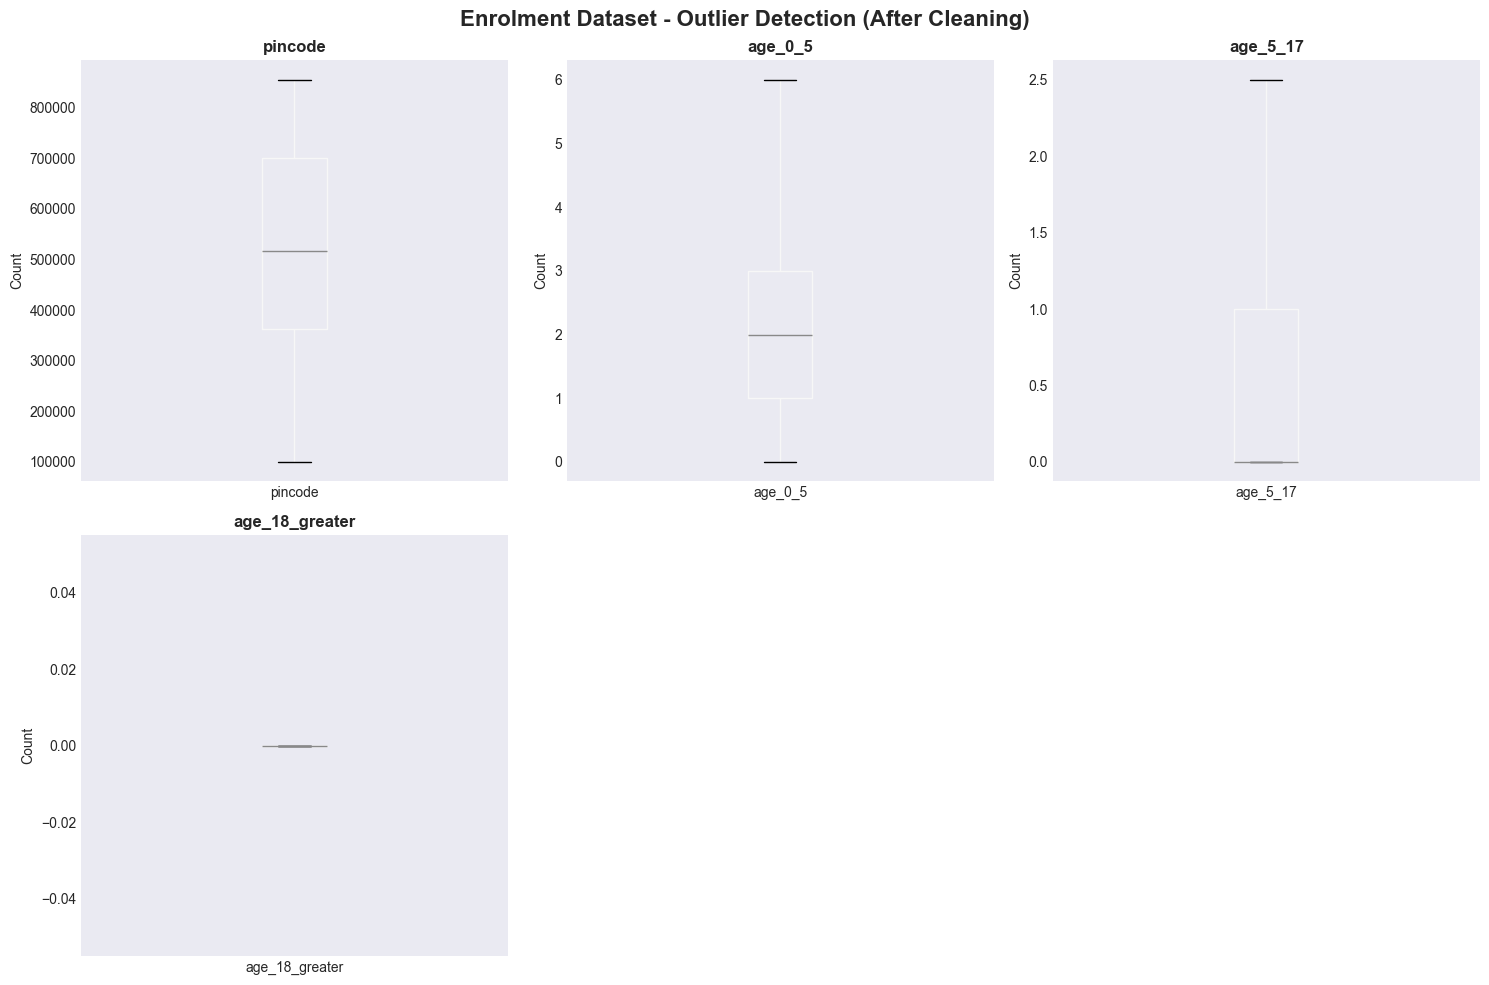

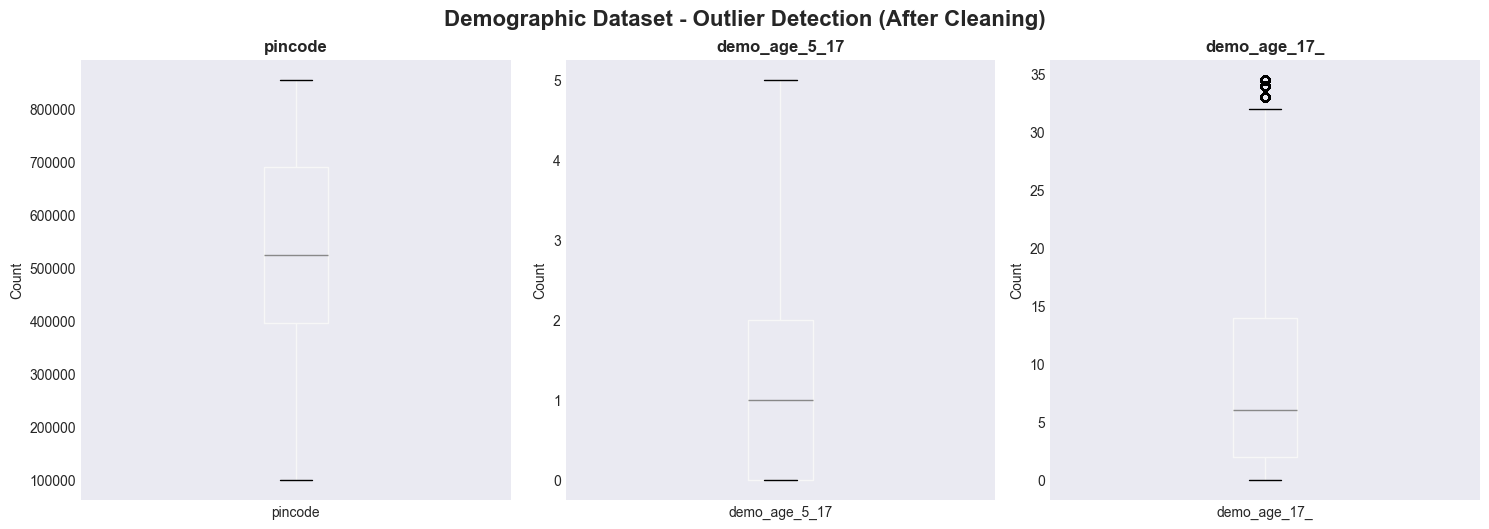

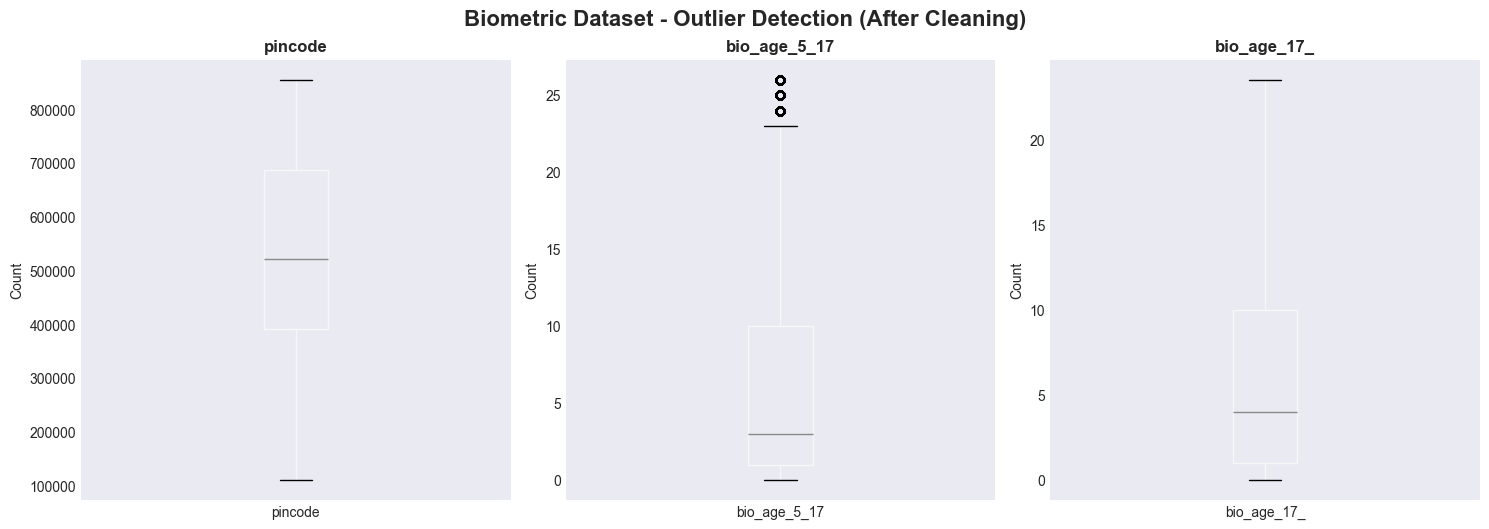

In [15]:
def plot_outlier_detection(df, dataset_name):
    """Create box plots to visualize outliers after cleaning"""
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if not numeric_cols:
        print(f"{dataset_name}: No numeric columns to visualize")
        return
    
    # Limit to first 6 numeric columns for better visualization
    cols_to_plot = numeric_cols[:6]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'{dataset_name} - Outlier Detection (After Cleaning)', fontsize=16, fontweight='bold')
    
    axes = axes.flatten()
    
    for idx, col in enumerate(cols_to_plot):
        if idx < len(axes):
            ax = axes[idx]
            df.boxplot(column=col, ax=ax, grid=False)
            ax.set_title(f'{col}', fontweight='bold')
            ax.set_ylabel('Count')
    
    # Hide empty subplots
    for idx in range(len(cols_to_plot), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

print("=" * 80)
print("OUTLIER DETECTION VISUALIZATIONS (AFTER CLEANING)")
print("=" * 80)

plot_outlier_detection(df_enrolment_clean, "Enrolment Dataset")
plot_outlier_detection(df_demographic_clean, "Demographic Dataset")
plot_outlier_detection(df_biometric_clean, "Biometric Dataset")

## 11. Visualizations: Outlier Detection (After Cleaning)

Visualize the distribution of numerical columns after outlier handling.

In [16]:
# Record final statistics
print("=" * 80)
print("FINAL DATA QUALITY STATISTICS (AFTER CLEANING)")
print("=" * 80)

final_stats = []
final_stats.append(record_statistics(df_enrolment_clean, 'Enrolment'))
final_stats.append(record_statistics(df_demographic_clean, 'Demographic'))
final_stats.append(record_statistics(df_biometric_clean, 'Biometric'))

final_stats_df = pd.DataFrame(final_stats)
display(final_stats_df)

print("\n" + "=" * 80)
print("BEFORE vs AFTER COMPARISON")
print("=" * 80)

# Create comparison DataFrame
comparison = pd.DataFrame({
    'Dataset': initial_stats_df['Dataset'],
    'Rows_Before': initial_stats_df['Total_Rows'],
    'Rows_After': final_stats_df['Total_Rows'],
    'Rows_Removed': initial_stats_df['Total_Rows'] - final_stats_df['Total_Rows'],
    'Rows_Removed_%': ((initial_stats_df['Total_Rows'] - final_stats_df['Total_Rows']) / initial_stats_df['Total_Rows'] * 100).round(2),
    'Missing_Before': initial_stats_df['Missing_Values'],
    'Missing_After': final_stats_df['Missing_Values'],
    'Duplicates_Before': initial_stats_df['Duplicate_Rows'],
    'Duplicates_After': final_stats_df['Duplicate_Rows'],
    'Negatives_Before': initial_stats_df['Negative_Values'],
    'Negatives_After': final_stats_df['Negative_Values']
})

display(comparison)

print("\n✓ Data quality significantly improved!")

FINAL DATA QUALITY STATISTICS (AFTER CLEANING)


,Dataset,Total_Rows,Total_Columns,Missing_Values,Missing_Percentage,Duplicate_Rows,Duplicate_Percentage,Negative_Values
0,Enrolment,966443,7,0,0.00,75,0.01,0
1,Demographic,1584531,6,0,0.00,87,0.01,0
2,Biometric,1744259,6,0,0.00,76,0.00,0



BEFORE vs AFTER COMPARISON


,Dataset,Rows_Before,Rows_After,Rows_Removed,Rows_Removed_%,Missing_Before,Missing_After,Duplicates_Before,Duplicates_After,Negatives_Before,Negatives_After
0,Enrolment,1006029,966443,39586,3.93,0,0,22957,75,0,0
1,Demographic,2071700,1584531,487169,23.52,0,0,473601,87,0,0
2,Biometric,1861108,1744259,116849,6.28,0,0,94896,76,0,0



✓ Data quality significantly improved!


## 12. Generate After-Cleaning Statistics and Comparison

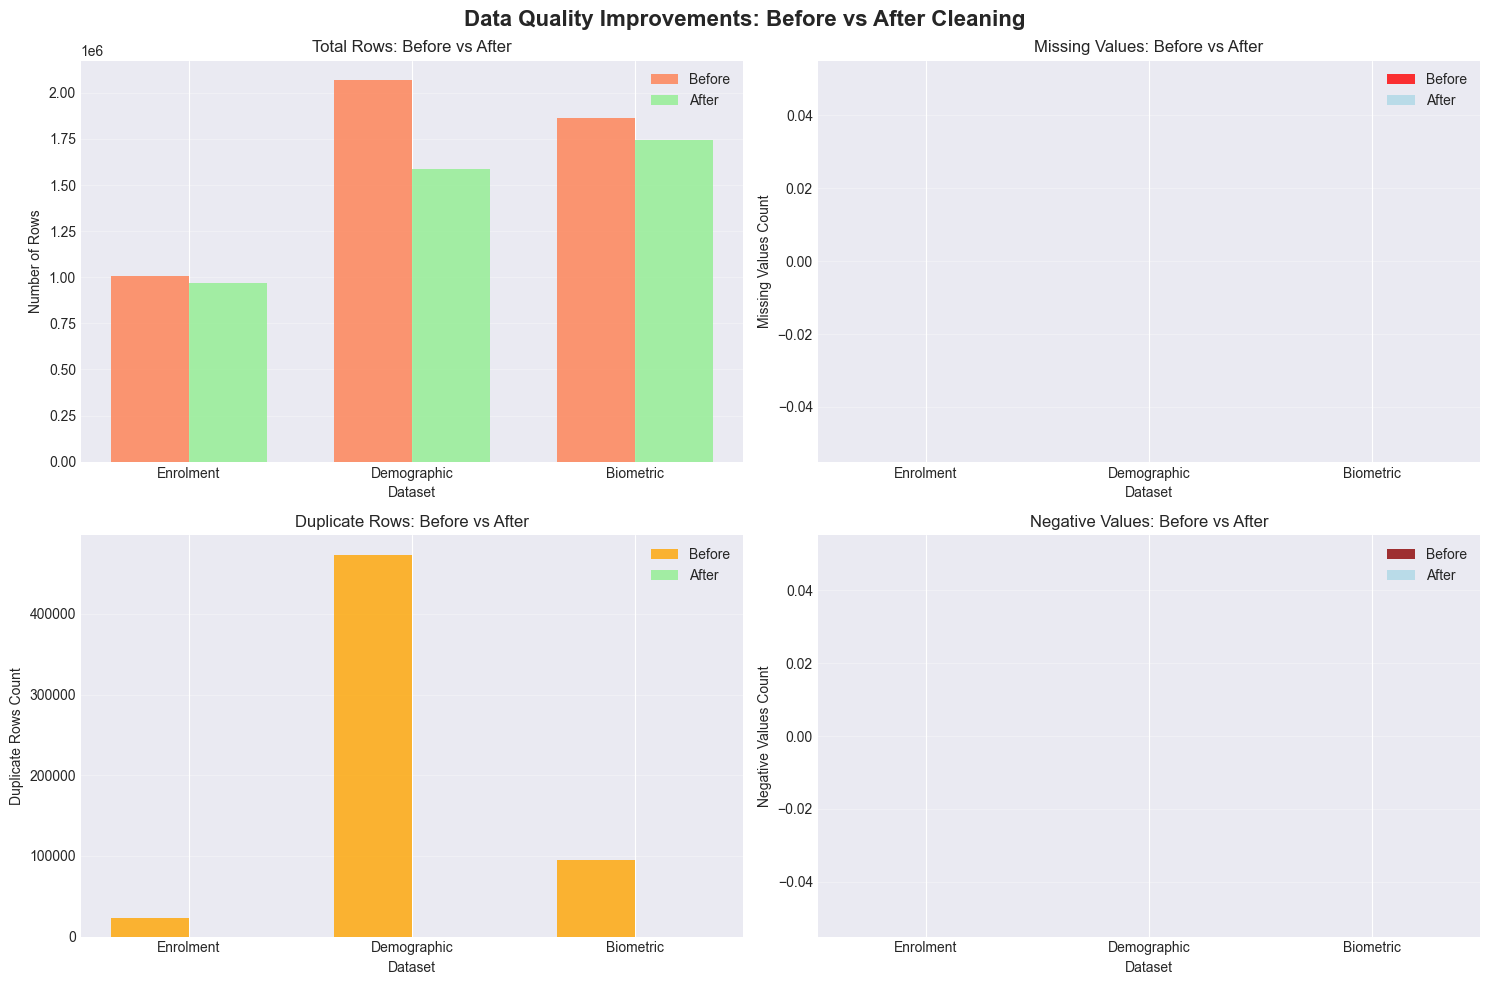

✓ Visualizations generated successfully!


In [17]:
# Visualize improvements
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Data Quality Improvements: Before vs After Cleaning', fontsize=16, fontweight='bold')

datasets_list = comparison['Dataset'].tolist()

# 1. Rows comparison
ax1 = axes[0, 0]
x = np.arange(len(datasets_list))
width = 0.35
ax1.bar(x - width/2, comparison['Rows_Before'], width, label='Before', color='coral', alpha=0.8)
ax1.bar(x + width/2, comparison['Rows_After'], width, label='After', color='lightgreen', alpha=0.8)
ax1.set_xlabel('Dataset')
ax1.set_ylabel('Number of Rows')
ax1.set_title('Total Rows: Before vs After')
ax1.set_xticks(x)
ax1.set_xticklabels(datasets_list)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Missing values
ax2 = axes[0, 1]
ax2.bar(x - width/2, comparison['Missing_Before'], width, label='Before', color='red', alpha=0.8)
ax2.bar(x + width/2, comparison['Missing_After'], width, label='After', color='lightblue', alpha=0.8)
ax2.set_xlabel('Dataset')
ax2.set_ylabel('Missing Values Count')
ax2.set_title('Missing Values: Before vs After')
ax2.set_xticks(x)
ax2.set_xticklabels(datasets_list)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Duplicates
ax3 = axes[1, 0]
ax3.bar(x - width/2, comparison['Duplicates_Before'], width, label='Before', color='orange', alpha=0.8)
ax3.bar(x + width/2, comparison['Duplicates_After'], width, label='After', color='lightgreen', alpha=0.8)
ax3.set_xlabel('Dataset')
ax3.set_ylabel('Duplicate Rows Count')
ax3.set_title('Duplicate Rows: Before vs After')
ax3.set_xticks(x)
ax3.set_xticklabels(datasets_list)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Negative values
ax4 = axes[1, 1]
ax4.bar(x - width/2, comparison['Negatives_Before'], width, label='Before', color='darkred', alpha=0.8)
ax4.bar(x + width/2, comparison['Negatives_After'], width, label='After', color='lightblue', alpha=0.8)
ax4.set_xlabel('Dataset')
ax4.set_ylabel('Negative Values Count')
ax4.set_title('Negative Values: Before vs After')
ax4.set_xticks(x)
ax4.set_xticklabels(datasets_list)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizations generated successfully!")

## 13. Visualize Data Quality Improvements

In [18]:
print("=" * 80)
print("SAVING CLEANED DATASETS")
print("=" * 80)

# Define output file paths
enrolment_output = OUTPUT_PATH / 'cleaned_enrolment.csv'
demographic_output = OUTPUT_PATH / 'cleaned_demographic.csv'
biometric_output = OUTPUT_PATH / 'cleaned_biometric.csv'

# Save cleaned datasets
print("\nSaving cleaned datasets...")

df_enrolment_clean.to_csv(enrolment_output, index=False)
print(f"✓ Saved: {enrolment_output}")
print(f"  Rows: {len(df_enrolment_clean):,} | Columns: {len(df_enrolment_clean.columns)}")

df_demographic_clean.to_csv(demographic_output, index=False)
print(f"✓ Saved: {demographic_output}")
print(f"  Rows: {len(df_demographic_clean):,} | Columns: {len(df_demographic_clean.columns)}")

df_biometric_clean.to_csv(biometric_output, index=False)
print(f"✓ Saved: {biometric_output}")
print(f"  Rows: {len(df_biometric_clean):,} | Columns: {len(df_biometric_clean.columns)}")

# Save comparison statistics
comparison_output = OUTPUT_PATH / 'cleaning_comparison.csv'
comparison.to_csv(comparison_output, index=False)
print(f"\n✓ Saved comparison statistics: {comparison_output}")

print("\n" + "=" * 80)
print("ALL CLEANED DATASETS SAVED SUCCESSFULLY!")
print("=" * 80)

SAVING CLEANED DATASETS

Saving cleaned datasets...
✓ Saved: /home/prince/Desktop/UIDAI Hackathon/outputs/results/cleaned_enrolment.csv
  Rows: 966,443 | Columns: 7
✓ Saved: /home/prince/Desktop/UIDAI Hackathon/outputs/results/cleaned_demographic.csv
  Rows: 1,584,531 | Columns: 6
✓ Saved: /home/prince/Desktop/UIDAI Hackathon/outputs/results/cleaned_biometric.csv
  Rows: 1,744,259 | Columns: 6

✓ Saved comparison statistics: /home/prince/Desktop/UIDAI Hackathon/outputs/results/cleaning_comparison.csv

ALL CLEANED DATASETS SAVED SUCCESSFULLY!


## 14. Save Cleaned Datasets

Save the cleaned datasets to the outputs/results directory.